# Import data and libraries 

In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

# Team toolbox
from feature_engineering.categorical import one_hot_embarked, one_hot_name, handle_cabin, process_ticket, handle_Pclass
from feature_engineering.missing_values import missing_values_table
from feature_engineering.continuous import continuous_features, basic_preprocessing, outliers_handling, fill_age, processing_age_features

In [2]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Remove duplicate index
test['Survived'] = -1*np.ones(test.shape[0])
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Features Engineering

## First Overview of Missing Values

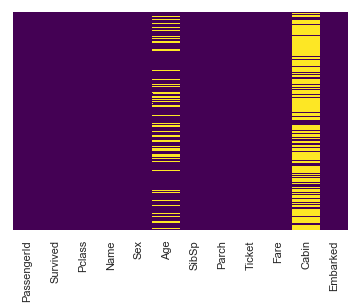

In [3]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<b>Missing values:</b> There are several variables (Age, Cabin) for which there are missing values. If not taken care of, this will have a detrimental effect on building predictive models. Some kind of models indeed need no missing values. However, we will not handle those missing values immediately as we need some more information on the dataset to compute them more effectively.

# Categorical Features

Some predictors are not suited for direct exploitation. For instance, variables like Name need feature engineering/extracting. We will therefore proceed with common sense and data-driven choices to create relevant features from these raw data. The features concerned are: Name, Cabin and Ticket. 

## Sex

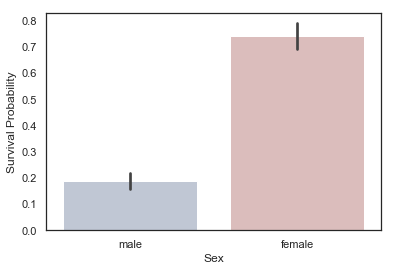

In [5]:
g = sns.barplot(x="Sex",y="Survived",data=train, palette ="vlag")
g = g.set_ylabel("Survival Probability")

It is clearly obvious that men have less chance to survive than women.
So Sex, might play an important role in the prediction of the survival.

## Name

<b>Titles:</b> After a careful analysis of the Name features, we observe the occurence of titles in lots of samples (Mr, Mrs, Lady, Dr, ...). These socio-economic markers probably have an importance. For instance, Lady and Countess might have a higher likelihood of getting on a lifeboat because of their status. The exhaustive list of found titles is: Jonkheer, Ms, Mlle, Mme, Capt, Don, Major, Col, Sir, Dona, Lady, the Countess. We will therefore parse the names and retrieve those keywords.

As we wee, most of the titles beside Mr, Mrs, Miss and Master have very low occurences. As the most common way to deal with such categorical features is to create dummy variables, the resulting imbalanced features will undermine Machine Learning models abilities to learn. We will therefore group some under broader categories:

- Ms, Mlle -> Miss (Obvious)
- Mme -> Mrs (Obvious)
- Jonkheer, Sir, Dona, Lady, the Countess -> Nobles (Jonkheer denotes the lowest rank within the nobility in the Low countries)
- Capt, Don, Major, Col -> Military (Military individuals are likely to help others when the ship is sinking, i.e. sense of duty)

After an attentive analysis of the barplot above, we see that following:

- Almost all nobles survived.
- Military and Reverents did not survive for the majority and the same goes for the doctors. 
It might be possible 

<b>Remark:</b> These features are highly correlated with the Sex of the individual. 'Military', 'Reverents' and 'Doctors' are all males (except for one female doctor).

Rev and Nobles seem to be strong indicators of survivorship. We will consequently retain them in our dataset. However, despite the above average survival likelihood, military titles and Doctors do not seem discriminative enough. We therefore group the two of them under 'Officer' (by lack of a better name).

However, given the small number of some of these titles, we will finally end up with 5 features: Mr, Master, Miss, Mrs, Rare (all the other ones)

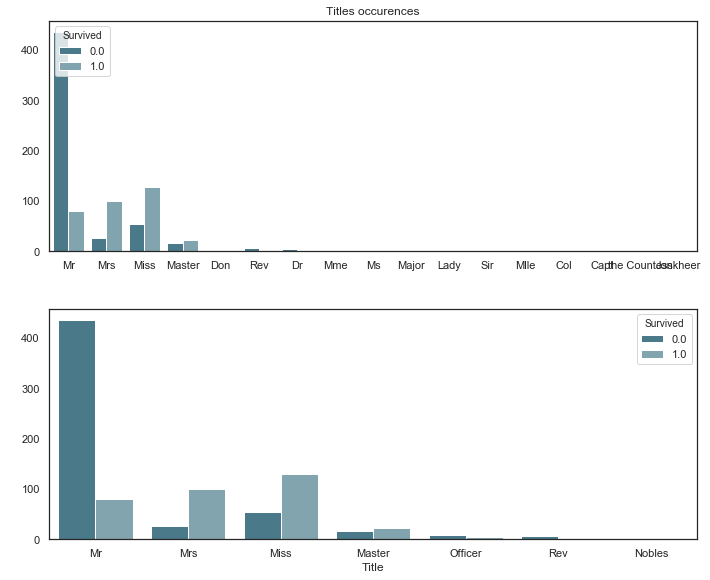

In [6]:
train, test = one_hot_name(train, test, plot = True)

In [7]:
#here is a list of the new features of the dataset
train.columns.values

array(['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'], dtype=object)

## Pclass

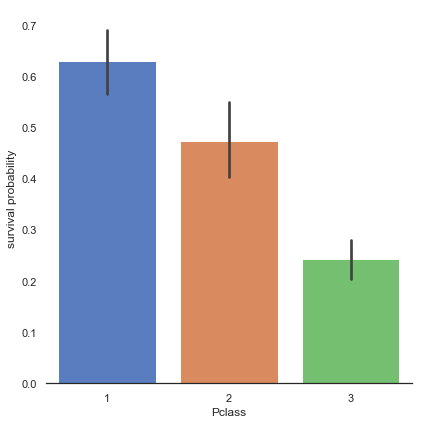

In [8]:
g = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It appears that first class passengers have more chances to survive than the others

## Embarked

The embarked feature defines the port of embarkation. There are two missing values, which we will replace by the most common port of Embarkation 'S'.

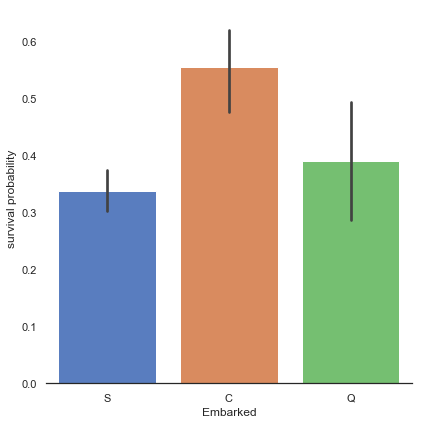

In [9]:
g = sns.catplot(x="Embarked", y="Survived",  data=train,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

We notice that the passengers who embarked from Cherbourg have more chances to survive. Why is that ? 

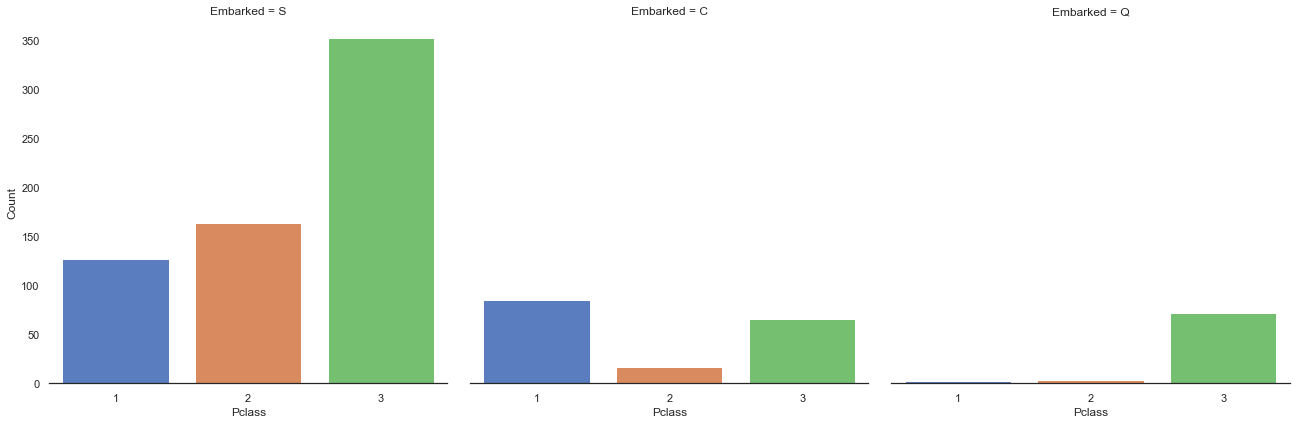

In [10]:
g = sns.catplot("Pclass", col="Embarked",  data=train,
                   height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

The third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

In [11]:
# Here we replace missing values in "Embarked" by "S"
train, test = one_hot_embarked(train, test)

In [12]:
#Let's have a look to the new features list
train.columns.values

array(['Age', 'Cabin', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'], dtype=object)

## Cabin

The cabin number is a tricky predictor as it has many missing values and is not directly usable. Furthermore it needs feature engineering. We should note that there are some samples with more than one cabin reservation. Intuitively, the residents of the cabin are likely to know each other, or at least the person who bought the ticket. It is also likely that people who know each other tend to stick together when in distess. We will take this into account in the following analysis.

We will create the following features:

<b>Deck<b>: First letter of the string, it corresponds to the floor of the titanic, as per the plan below.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png" width="240" height="240" align="center"/>



We observe a few things:

- Some categories don't have enough informations and should therefore be merged together
- There are different likelihood of survival depending on the category

We will choose the groups based on the likelihood of survival

- T, GF, U - > Low (0 to 30% likelihood)
- A, C, G -> Medium (between 30% and 70% likelihood)
- EF, F, D, E -> High (superior to 70 %)


<b>Cabin number:</b> According to [this plan](https://www.encyclopedia-titanica.org/titanic-deckplans/c-deck.html) of the deck, the number is distributed with regards to the boat length (low numbers at the front of the boat and high ones at the end). We will consider the room number as a continuous variables. It will make our task easier for both the preprocessing and the the imputation.

<b>Number of cabins:</b>  A careful inspection of the number of cabins vs survival likelihood shows that people with more than two cabin have a higher survival rate. We add a Boolean variable that indicates wether the reservation has two cabins or more.

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Age             float64
Fare            float64
Parch             int64
PassengerId       int64
Pclass            int64
Sex              object
SibSp             int64
Survived        float64
Ticket           object
Title_Master      uint8
Title_Miss        uint8
Title_Mr          uint8
Title_Mrs         uint8
Title_Rare        uint8
Embarked_C        uint8
Embarked_Q        uint8
Embarked_S        uint8
Deck_High         uint8
Deck_Low          uint8
Deck_Medium       uint8
NumberCabins      int64
Room            float64
dtype: object


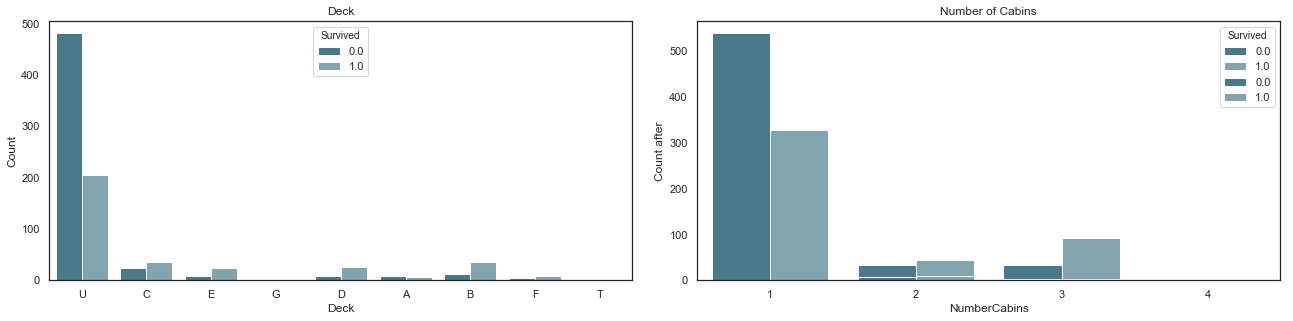

In [13]:
train, test = handle_cabin(train, test, plot = True)
print(train.dtypes)

## Ticket

First, the raw feature ticket is unexploitable as is. We extract the prefixes as well as the ticket IDs. The intuiton behind those choices is that tickets sharing the same prefixes could be booked for cabins placed together and lead to the actual placement of the cabins within the ship. Furthermore, tickets with same prefixes may have a similar class and survival. Finally, we apply dummy encoding of the prefix ids and we reduce the dimension of the encoding (because there are more than 30 factors!). To this end, wedelete features with less than 95% and group those with similar survival likelihood.

The number associated to each prefix is likely irrelevant and furthermore missing in a lot of samples. Furthermore, they might not even be ordinal data and some kinf of identifications. We omit this noisy feature by sake of simplicity.

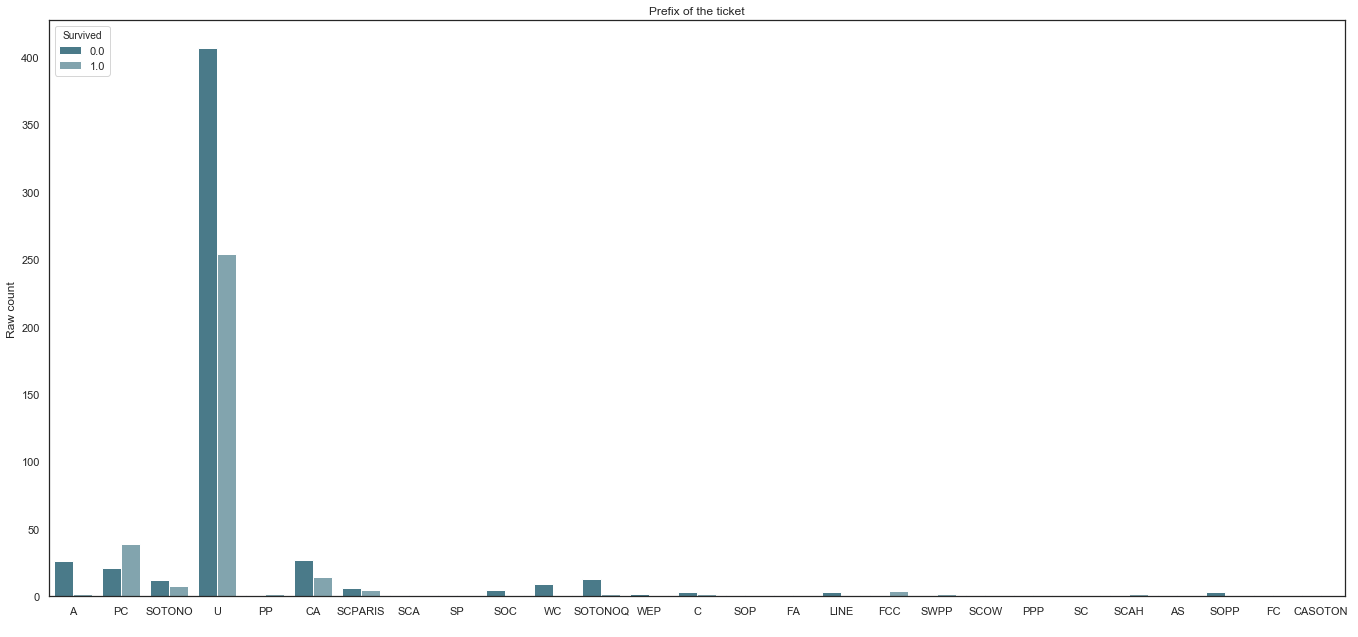

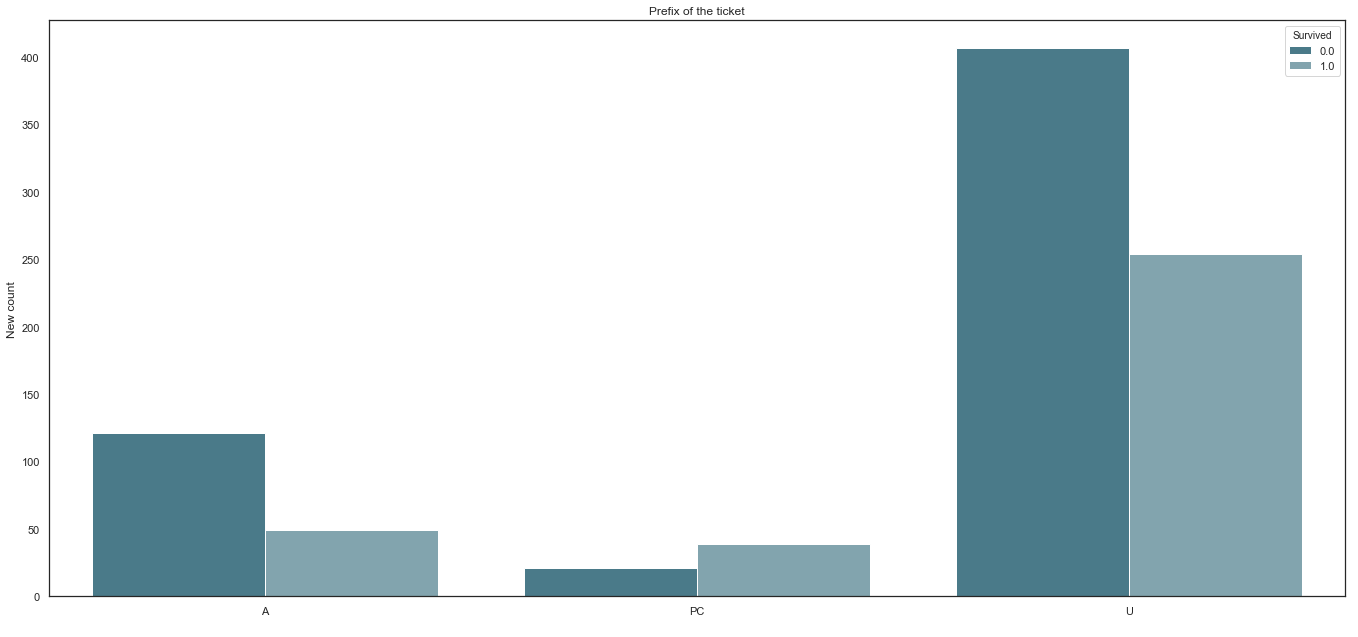

In [14]:
train, test = process_ticket(train, test, plot=True)

In [15]:
train.columns.values

array(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rare', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Deck_High', 'Deck_Low', 'Deck_Medium', 'NumberCabins', 'Room',
       'TicketPrefix_A', 'TicketPrefix_PC', 'TicketPrefix_U'],
      dtype=object)

# Numerical Features

The two ordinal features Parch and SibSp both correspond to the number of family individuals. We will therefore merge the two by summing them into a new feature: 'Family'.

In [16]:
train, test = basic_preprocessing(train, test)

In [17]:
train.columns.values

array(['Age', 'Fare', 'PassengerId', 'Pclass', 'Sex', 'Survived',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rare', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Deck_High', 'Deck_Low', 'Deck_Medium', 'NumberCabins', 'Room',
       'TicketPrefix_A', 'TicketPrefix_PC', 'TicketPrefix_U', 'Family',
       'IsAlone'], dtype=object)

# Age

As we see, Age column contains 256 missing values in the whole dataset.
Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

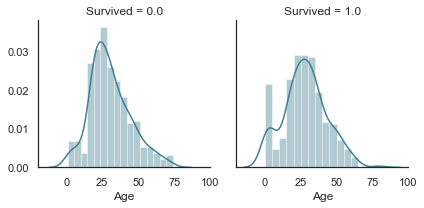

In [18]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

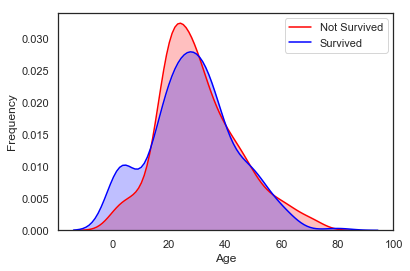

In [19]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Here we aim to fill the missing values for "Age". We made the hypothesis that passengers that have the same sex, title and class could have approximately the same age. So this function groups passengers that have the same features as mentioned above and compute the median for each group. Then it replaces each missing value with the corresponding mean

In [20]:
processing_age_features(train,train.shape[0])

,Age,Fare,PassengerId,Pclass,Sex,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Deck_High,Deck_Low,Deck_Medium,NumberCabins,Room,TicketPrefix_A,TicketPrefix_PC,TicketPrefix_U,Family,IsAlone
0,22.0,7.2500,1,3,1,0.0,0,0,1,0,...,0,1,0,1,0.0,1,0,0,2,0
1,38.0,71.2833,2,1,0,1.0,0,0,0,1,...,0,0,1,1,85.0,0,1,0,2,0
2,26.0,7.9250,3,3,0,1.0,0,1,0,0,...,0,1,0,1,0.0,1,0,0,1,1
3,35.0,53.1000,4,1,0,1.0,0,0,0,1,...,0,0,1,1,123.0,0,0,1,2,0
4,35.0,8.0500,5,3,1,0.0,0,0,1,0,...,0,1,0,1,0.0,0,0,1,1,1
5,26.0,8.4583,6,3,1,0.0,0,0,1,0,...,0,1,0,1,0.0,0,0,1,1,1
6,54.0,51.8625,7,1,1,0.0,0,0,1,0,...,1,0,0,1,46.0,0,0,1,1,1
7,2.0,21.0750,8,3,1,0.0,1,0,0,0,...,0,1,0,1,0.0,0,0,1,5,0
8,27.0,11.1333,9,3,0,1.0,0,0,0,1,...,0,1,0,1,0.0,0,0,1,3,0
9,14.0,30.0708,10,2,0,1.0,0,0,0,1,...,0,1,0,1,0.0,0,0,1,2,0


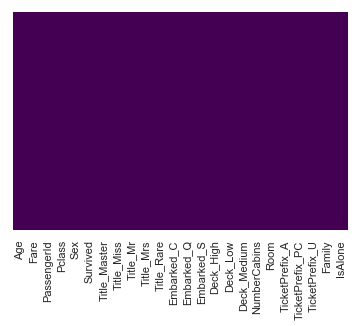

In [21]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [22]:
#We do the same for test
processing_age_features(test,test.shape[0])

,Age,Fare,PassengerId,Pclass,Sex,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Deck_High,Deck_Low,Deck_Medium,NumberCabins,Room,TicketPrefix_A,TicketPrefix_PC,TicketPrefix_U,Family,IsAlone
0,34.5,7.8292,892,3,1,-1.0,0,0,1,0,...,0,1,0,1,0.0,0,0,1,1,1
1,47.0,7.0000,893,3,0,-1.0,0,0,0,1,...,0,1,0,1,0.0,0,0,1,2,0
2,62.0,9.6875,894,2,1,-1.0,0,1,0,0,...,0,1,0,1,0.0,0,0,1,1,1
3,27.0,8.6625,895,3,1,-1.0,0,0,0,1,...,0,1,0,1,0.0,0,0,1,1,1
4,22.0,12.2875,896,3,0,-1.0,0,0,1,0,...,0,1,0,1,0.0,0,0,1,3,0
5,14.0,9.2250,897,3,1,-1.0,0,0,1,0,...,0,1,0,1,0.0,0,0,1,1,1
6,30.0,7.6292,898,3,0,-1.0,0,0,1,0,...,0,1,0,1,0.0,0,0,1,1,1
7,26.0,29.0000,899,2,1,-1.0,1,0,0,0,...,0,1,0,1,0.0,0,0,1,3,0
8,18.0,7.2292,900,3,0,-1.0,0,0,0,1,...,0,1,0,1,0.0,0,0,1,1,1
9,21.0,24.1500,901,3,1,-1.0,0,0,0,1,...,0,1,0,1,0.0,1,0,0,3,0


1

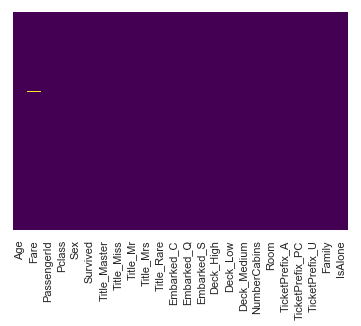

In [23]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')
test["Age"].isnull().sum()

It appears that we still have a missing value in test. As it is only one, we can replace it by the median

In [24]:
test["Age"] = test["Age"].fillna(test["Age"].median())

We can now also transform Pclass into a categorical variable

In [25]:
train, test = handle_Pclass(train, test)

In [26]:
train.columns.values

array(['Age', 'Fare', 'PassengerId', 'Sex', 'Survived', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_High', 'Deck_Low', 'Deck_Medium',
       'NumberCabins', 'Room', 'TicketPrefix_A', 'TicketPrefix_PC',
       'TicketPrefix_U', 'Family', 'IsAlone', 'Pc_1', 'Pc_2', 'Pc_3'],
      dtype=object)

## Fare

First it appears that we have a missing value in test. As it is only one, we can replace it by the median

In [27]:
test["Fare"].isnull().sum()

1

In [28]:
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

Let's see how the variable is ditributed

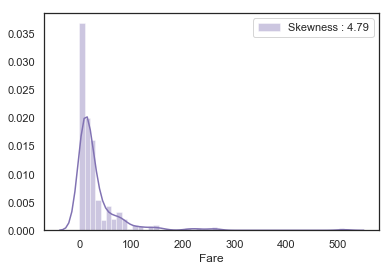

In [29]:
g = sns.distplot(train["Fare"], color="m", label="Skewness : %.2f"%(train["Fare"].skew()))
g = g.legend(loc="best")

Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

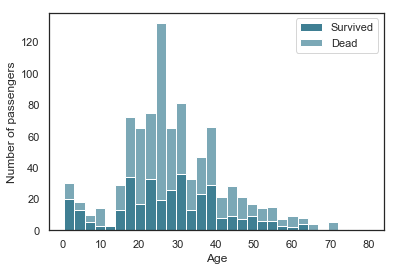

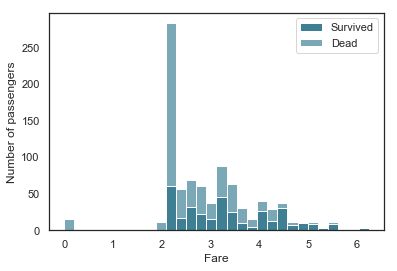

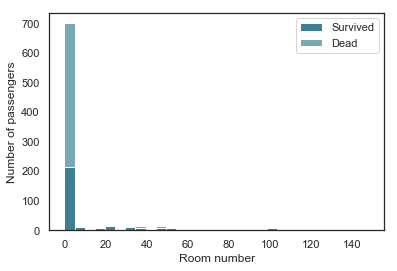

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/simoalami/Documents/Centrale/Machine Learning/ML-DSBA-AI-Assignment_2/titanic/feature_engineering/continuous.py:53: DataConversionWarning: Data with input dtype int64, float64 were all converted to flo

In [30]:
train, test = continuous_features(train, test)

In [31]:
train.columns.values

array(['Age', 'Deck_High', 'Deck_Low', 'Deck_Medium', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Family', 'Fare', 'IsAlone',
       'NumberCabins', 'PassengerId', 'Pc_1', 'Pc_2', 'Pc_3', 'Room',
       'Sex', 'Survived', 'TicketPrefix_A', 'TicketPrefix_PC',
       'TicketPrefix_U', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'LogFare'], dtype=object)

Here is what the distribution looks like after transformation

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


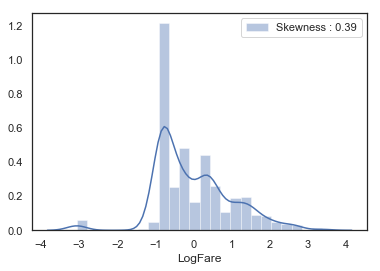

In [32]:
g = sns.distplot(train["LogFare"], color="b", label="Skewness : %.2f"%(train["LogFare"].skew()))
g = g.legend(loc="best")

## Outlier Detection and Analysis

Outliers, even if there are only few of them, can have a massive impact on supervided algorithms. For instance, if we consider linear regression, one outlier can totaly change the slope of the curve. 

If not taken care of, outliers have detrimental effects on predictive models. We will use the local outlier factor, an algorithm for finding anomalous data points by measuring the local deviation of a given data point with respect to its neighbours. 

The Local Outlier Factor score quantifies the typical distance at which a point can be "reached" from its neighbors. This technique works well when dealing with low dimensional data (such as our use case) because it does not suffer much from the curse of dimensionality.

After inspections of the scores density among training samples, we remove the ten observations with the highest scores (heavy tail of the LOF score distribution). 


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


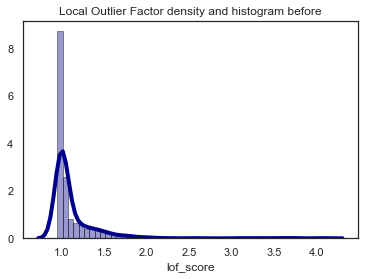

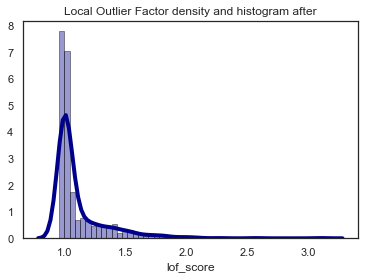

In [33]:
train = outliers_handling(train, plot=True)

## Multicollinearity Matrix

Linear based models suffer from multicollinearity. Therefore, if we find any colinear features we should merge them in order to fix the issue

In [ ]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,\
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Feature selection

In [33]:
# Predictor / response split
X_train, y_train = train.drop(['Survived', 'PassengerId'], axis = 1), train['Survived']
X_test, y_test = test.drop(['Survived', 'PassengerId'], axis = 1), test['Survived']

Using a random forest classifier we were able to compute the gini indicator of each feature and rank according to their importance. We then plotted the 14 features with the largest scores.

The reason we chose this strategy is because tree-based strategies used by random forests naturally rank by how well they improve the purity of the node. 

('Age', 0.12288039773318744)
('Deck_High', 0.012681117533573568)
('Deck_Low', 0.01946690282501315)
('Deck_Medium', 0.0045022803029269405)
('Embarked_C', 0.009212370217602421)
('Embarked_Q', 0.007047352530760871)
('Embarked_S', 0.011827121665969349)
('Family', 0.047677875507123525)
('Fare', 0.09513492433718121)
('IsAlone', 0.010435393944483892)
('NumberCabins', 0.002475784969922302)
('Pc_1', 0.010945618848634896)
('Pc_2', 0.013471068847364563)
('Pc_3', 0.034755052151793336)
('Room', 0.03881082664708244)
('Sex', 0.10863946701759421)
('TicketPrefix_A', 0.009187390771001466)
('TicketPrefix_PC', 0.0035793516570735875)
('TicketPrefix_U', 0.010428897658015558)
('Title_Master', 0.00847677164971493)
('Title_Miss', 0.03215562693500871)
('Title_Mr', 0.11158255176662826)
('Title_Mrs', 0.030842008855822233)
('Title_Rare', 0.007242663890329078)
('LogFare', 0.09456999872886392)
('lof_score', 0.14197118300732803)


Text(0.5, 1.0, 'Features importance')

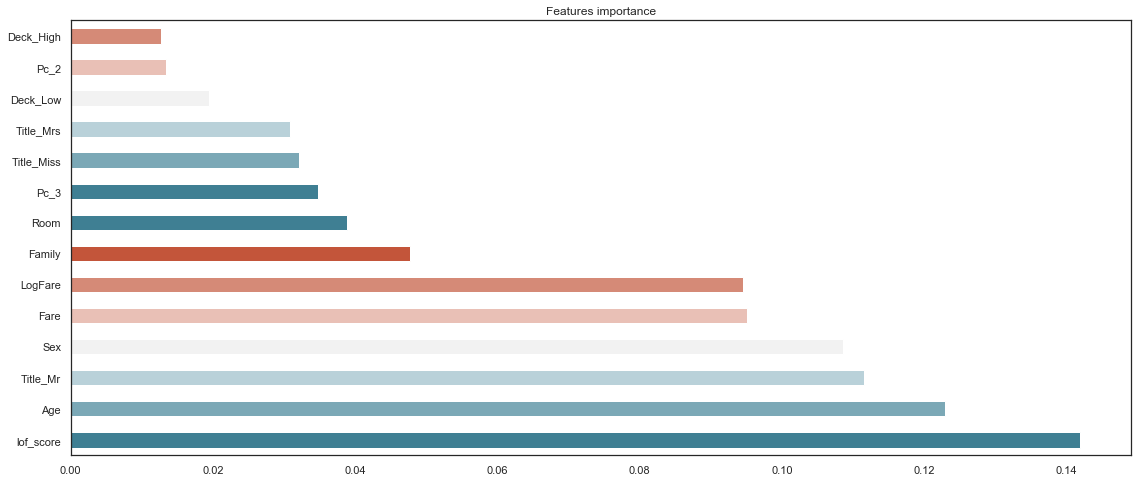

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(X_train.columns.values, clf.feature_importances_):
    print(feature)
    
# Plot results
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .nlargest(14)
   .plot(kind='barh', figsize = (19, 8))).set_title('Features importance')